# What Makes a Song Popular on Spotify?
## An Exploratory Data Analysis of Audio Features and Song Popularity

**DS5610 EDA: Final Project**  
**Date**: 10 Dec 2025
**Group Members**: Jay Ruan, Michael Fudge, Ida Metiam  

---
## 1. Introduction

### Background

In the digital age, music streaming has revolutionized how we discover and consume music. Spotify, launched in 2008, has become the world's most popular audio streaming platform. Understanding what makes a song popular on Spotify is valuable for:

- **Artists and Producers**: To create music that resonates with audiences
- **Record Labels**: To identify potential hit songs
- **Music Industry**: To understand changing trends in popular music
- **Researchers**: To study the evolution of musical preferences

### Research Question

**Primary Question**: What audio features and characteristics are most strongly associated with song popularity on Spotify?

**Sub-questions**:
1. Which individual audio features correlate most strongly with popularity?
2. How does popularity vary across different music genres?
3. Have popularity trends changed over time?
4. Can we predict a song's popularity based on its audio features?

### Dataset Overview

We use the "Spotify Top 2000s Mega Dataset" from Kaggle, which contains approximately 2,000 top songs from Spotify with detailed audio feature measurements. The dataset includes:

- **Audio Features**: Energy, Danceability, Loudness, Valence, Acousticness, and more
- **Metadata**: Song title, artist, genre, year of release
- **Target Variable**: Popularity score (0-100)

This dataset allows us to systematically analyze what makes songs successful on the platform.

---
## 2. Setup and Data Loading

First, we'll load the necessary libraries and import our data.

In [89]:
# Install required packages (run this cell first if you get import errors)
import sys
!{sys.executable} -m pip install --quiet matplotlib seaborn scipy scikit-learn

In [90]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [91]:
# Load the dataset
# UPDATE THIS PATH to match your downloaded file
df_raw = pd.read_csv('Spotify-2000.csv', encoding='ISO-8859-1')

print(f"Dataset loaded successfully!")
print(f"Shape: {df_raw.shape[0]} songs, {df_raw.shape[1]} features")

Dataset loaded successfully!
Shape: 1994 songs, 15 features


---
## 3. Data Overview and Initial Exploration

Let's examine the structure and contents of our dataset.

In [92]:
# Display first few rows
print("First 5 rows of the dataset:")
df_raw.head()

First 5 rows of the dataset:


,ï»¿Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


In [93]:
# Display dataset information
print("Dataset Information:")
df_raw.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ï»¿Index                1994 non-null   int64 
 1   Title                   1994 non-null   object
 2   Artist                  1994 non-null   object
 3   Top Genre               1994 non-null   object
 4   Year                    1994 non-null   int64 
 5   Beats Per Minute (BPM)  1994 non-null   int64 
 6   Energy                  1994 non-null   int64 
 7   Danceability            1994 non-null   int64 
 8   Loudness (dB)           1994 non-null   int64 
 9   Liveness                1994 non-null   int64 
 10  Valence                 1994 non-null   int64 
 11  Length (Duration)       1994 non-null   object
 12  Acousticness            1994 non-null   int64 
 13  Speechiness             1994 non-null   int64 
 14  Popularity              1994 non-nu

In [94]:
# Check for missing values
print("Missing values per column:")
missing_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing Count': df_raw.isnull().sum(),
    'Missing %': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
missing_df[missing_df['Missing Count'] > 0]

Missing values per column:


,Column,Missing Count,Missing %


### Understanding the Audio Features

Spotify uses advanced audio analysis to quantify various characteristics of each song. Here's what each feature measures:

| Feature | Description | Range |
|---------|-------------|-------|
| **Popularity** | How popular the song is on Spotify (our target variable) | 0-100 |
| **Danceability** | How suitable the song is for dancing based on tempo, rhythm, beat strength | 0-100 |
| **Energy** | Intensity and activity level - energetic songs feel fast, loud, and noisy | 0-100 |
| **Loudness** | Overall loudness in decibels (dB) | Typically -60 to 0 dB |
| **Valence** | Musical positiveness - high valence sounds happy/cheerful, low sounds sad/angry | 0-100 |
| **Acousticness** | Confidence measure of whether the track is acoustic | 0-100 |
| **Speechiness** | Presence of spoken words in a track | 0-100 |
| **Liveness** | Probability that the song was performed live (presence of audience) | 0-100 |
| **BPM** | Beats per minute - the tempo of the song | Typically 60-200 |
| **Duration** | Length of the song | Seconds or minutes |

---
## 4. Data Cleaning and Preparation

Before analysis, we need to clean and prepare our data. This includes handling missing values, removing duplicates, and standardizing column names.

In [95]:
# Create a copy for cleaning
df = df_raw.copy()

# Standardize column names (remove extra spaces)
df.columns = df.columns.str.strip()

print("Column names:")
print(df.columns.tolist())

Column names:
['ï»¿Index', 'Title', 'Artist', 'Top Genre', 'Year', 'Beats Per Minute (BPM)', 'Energy', 'Danceability', 'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)', 'Acousticness', 'Speechiness', 'Popularity']


In [96]:
# Check for and remove duplicates
initial_rows = len(df)
df = df.drop_duplicates()
duplicates_removed = initial_rows - len(df)

print(f"Duplicate rows removed: {duplicates_removed}")
print(f"Rows after cleaning: {len(df)}")

Duplicate rows removed: 0
Rows after cleaning: 1994


In [97]:
# Handle missing values in the popularity column (our target variable)
if 'Popularity' in df.columns:
    before_drop = len(df)
    df = df.dropna(subset=['Popularity'])
    after_drop = len(df)
    print(f"Rows with missing Popularity removed: {before_drop - after_drop}")
else:
    print("Popularity column not found - check column names")

Rows with missing Popularity removed: 0


In [98]:
# Identify numerical features for analysis
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove non-feature columns like Index or Year if present
exclude_cols = ['Index', 'index', 'ï»¿Index']
feature_cols = [col for col in numerical_cols if col not in exclude_cols and col != 'Popularity']

print(f"\nNumerical features for analysis ({len(feature_cols)}):")
for col in feature_cols:
    print(f"  - {col}")


Numerical features for analysis (9):
  - Year
  - Beats Per Minute (BPM)
  - Energy
  - Danceability
  - Loudness (dB)
  - Liveness
  - Valence
  - Acousticness
  - Speechiness


**Data Cleaning Summary:**
- Removed duplicate entries
- Handled missing values in critical columns
- Standardized column names for consistency
- Identified numerical features for analysis

---
## 5. Descriptive Statistics

Let's examine the basic statistics of our dataset to understand the distribution and range of values.

In [99]:
# Display summary statistics
summary_stats = df[['Popularity'] + feature_cols].describe().round(2)
summary_stats

,Popularity,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Acousticness,Speechiness
count,1994.00,1994.00,1994.00,1994.00,1994.00,1994.00,1994.00,1994.00,1994.00,1994.00
mean,59.53,1992.99,120.22,59.68,53.24,-9.01,19.01,49.41,28.86,4.99
std,14.35,16.12,28.03,22.15,15.35,3.65,16.73,24.86,29.01,4.40
min,11.00,1956.00,37.00,3.00,10.00,-27.00,2.00,3.00,0.00,2.00
25%,49.25,1979.00,99.00,42.00,43.00,-11.00,9.00,29.00,3.00,3.00
50%,62.00,1993.00,119.00,61.00,53.00,-8.00,12.00,47.00,18.00,4.00
75%,71.00,2007.00,136.00,78.00,64.00,-6.00,23.00,69.75,50.00,5.00
max,100.00,2019.00,206.00,100.00,96.00,-2.00,99.00,99.00,99.00,55.00


### Key Observations from Descriptive Statistics:

*After running the code, interpret the results here. For example:*

- **Popularity Range**: Songs in our dataset range from [min] to [max] with an average of [mean]
- **Most Variable Features**: [Identify features with highest standard deviation]
- **Central Tendencies**: [Discuss median vs mean for key features]

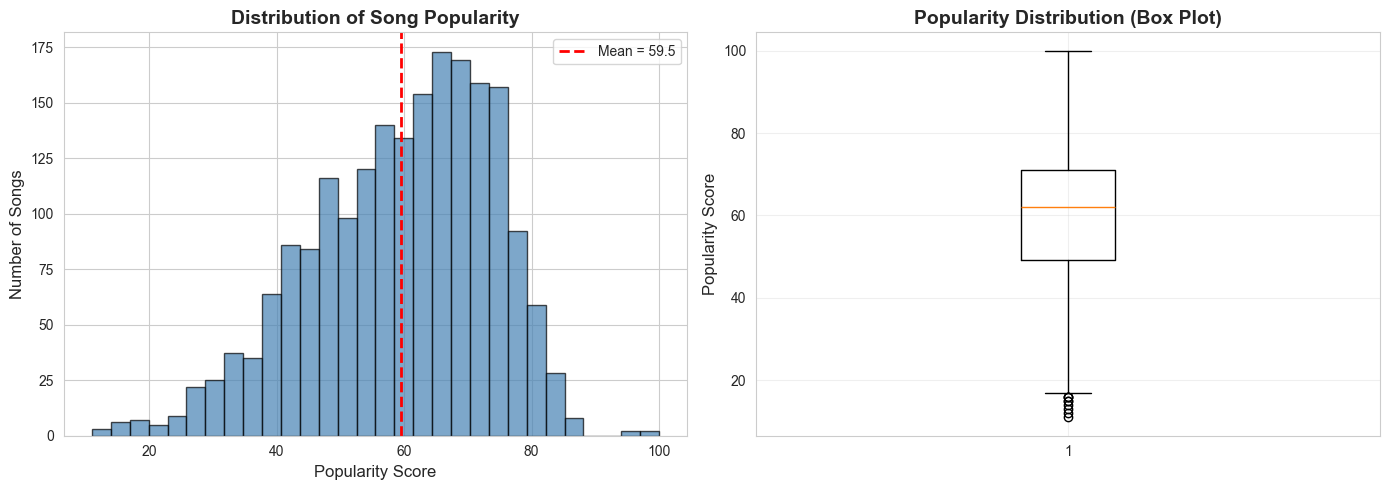

Popularity Statistics:
  Mean: 59.53
  Median: 62.00
  Std Dev: 14.35
  Range: 11 - 100


In [100]:
# Visualize the distribution of Popularity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['Popularity'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Popularity Score', fontsize=12)
axes[0].set_ylabel('Number of Songs', fontsize=12)
axes[0].set_title('Distribution of Song Popularity', fontsize=14, fontweight='bold')
axes[0].axvline(df['Popularity'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {df["Popularity"].mean():.1f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['Popularity'], vert=True)
axes[1].set_ylabel('Popularity Score', fontsize=12)
axes[1].set_title('Popularity Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('popularity_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Popularity Statistics:")
print(f"  Mean: {df['Popularity'].mean():.2f}")
print(f"  Median: {df['Popularity'].median():.2f}")
print(f"  Std Dev: {df['Popularity'].std():.2f}")
print(f"  Range: {df['Popularity'].min():.0f} - {df['Popularity'].max():.0f}")

**Figure 1**: Distribution of song popularity scores. The histogram (left) shows how popularity scores are distributed across all songs, while the box plot (right) highlights the median, quartiles, and potential outliers.

---
## 6. Global Properties: Correlation Analysis

Now we'll examine how different audio features relate to popularity across all songs in the dataset.

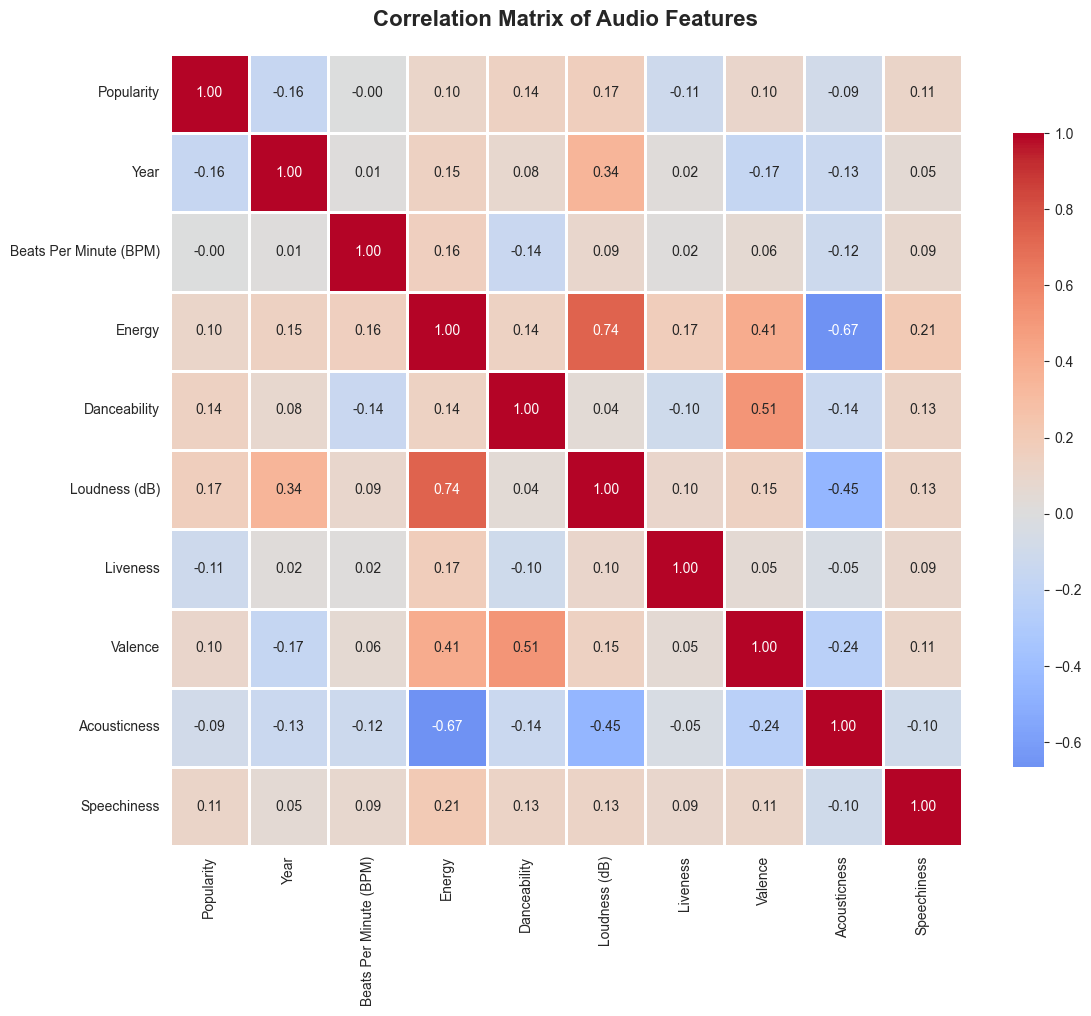

In [101]:
# Calculate correlation matrix
correlation_features = ['Popularity'] + feature_cols
correlation_matrix = df[correlation_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Audio Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

**Figure 2**: Correlation matrix showing relationships between all audio features. Red colors indicate positive correlations, blue colors indicate negative correlations. Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation).

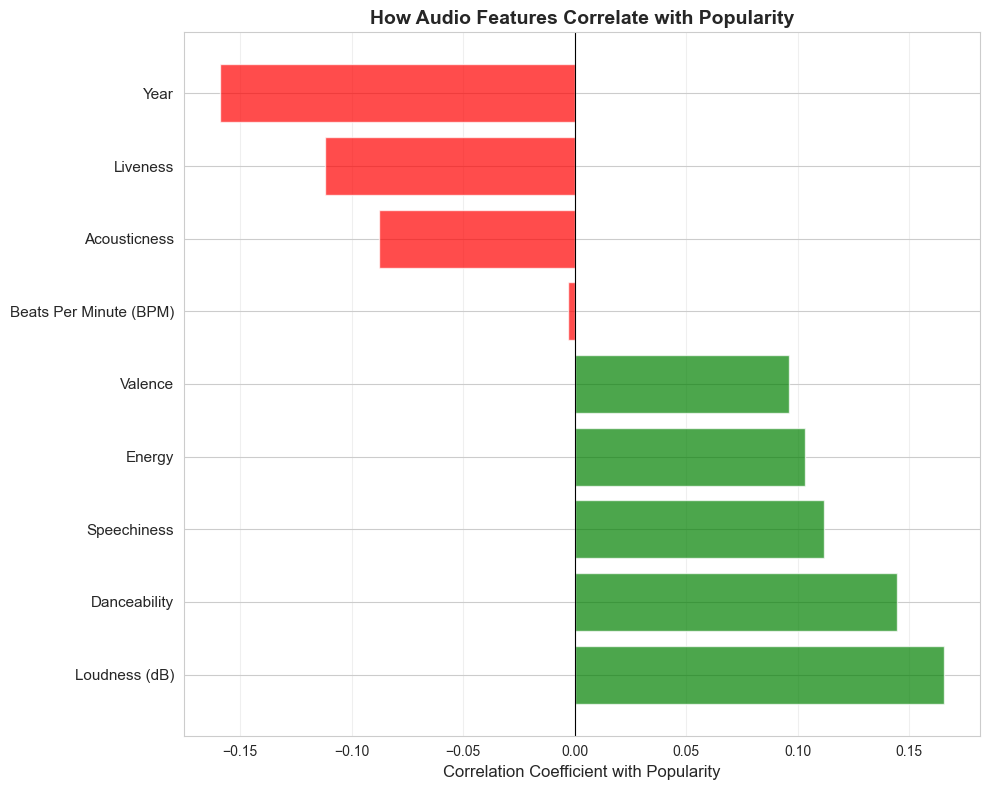


Correlation with Popularity (strongest to weakest):
               Feature  Correlation Strength
         Loudness (dB)        0.166 Moderate
          Danceability        0.144 Moderate
           Speechiness        0.112 Moderate
                Energy        0.103 Moderate
               Valence        0.096     Weak
Beats Per Minute (BPM)       -0.003     Weak
          Acousticness       -0.088     Weak
              Liveness       -0.112 Moderate
                  Year       -0.159 Moderate


In [102]:
# Extract and visualize correlations with Popularity
popularity_corr = correlation_matrix['Popularity'].drop('Popularity').sort_values(ascending=False)

# Create horizontal bar chart
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in popularity_corr]
bars = plt.barh(range(len(popularity_corr)), popularity_corr, color=colors, alpha=0.7)
plt.yticks(range(len(popularity_corr)), popularity_corr.index, fontsize=11)
plt.xlabel('Correlation Coefficient with Popularity', fontsize=12)
plt.title('How Audio Features Correlate with Popularity', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('popularity_correlations.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print correlation table
print("\nCorrelation with Popularity (strongest to weakest):")
print("=" * 50)
corr_table = pd.DataFrame({
    'Feature': popularity_corr.index,
    'Correlation': popularity_corr.values.round(3),
    'Strength': ['Strong' if abs(x) > 0.3 else 'Moderate' if abs(x) > 0.1 else 'Weak' 
                 for x in popularity_corr.values]
})
print(corr_table.to_string(index=False))

**Figure 3**: Bar chart showing how strongly each audio feature correlates with popularity. Green bars indicate positive relationships (as feature increases, popularity tends to increase), while red bars indicate negative relationships.

### Statistical Significance Testing

We'll test whether the observed correlations are statistically significant (p < 0.05).

In [103]:
# Perform statistical significance testing
significance_results = []

for feature in feature_cols:
    if feature in df.columns:
        # Calculate Pearson correlation and p-value
        clean_data = df[[feature, 'Popularity']].dropna()
        corr, p_value = stats.pearsonr(clean_data[feature], clean_data['Popularity'])
        
        significance_results.append({
            'Feature': feature,
            'Correlation': round(corr, 4),
            'P-value': round(p_value, 6),
            'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
        })

# Create and display results table
sig_df = pd.DataFrame(significance_results).sort_values('Correlation', ascending=False, key=abs)
print("\nStatistical Significance of Correlations:")
print("=" * 70)
print(sig_df.to_string(index=False))


Statistical Significance of Correlations:
               Feature  Correlation  P-value Significant (p<0.05)
         Loudness (dB)       0.1655 0.000000                  Yes
                  Year      -0.1590 0.000000                  Yes
          Danceability       0.1443 0.000000                  Yes
              Liveness      -0.1120 0.000001                  Yes
           Speechiness       0.1117 0.000001                  Yes
                Energy       0.1034 0.000004                  Yes
               Valence       0.0959 0.000018                  Yes
          Acousticness      -0.0876 0.000090                  Yes
Beats Per Minute (BPM)      -0.0032 0.887102                   No


**Interpretation Guide:**
- **P-value < 0.05**: The correlation is statistically significant (unlikely to occur by chance)
- **P-value ≥ 0.05**: The correlation is not statistically significant

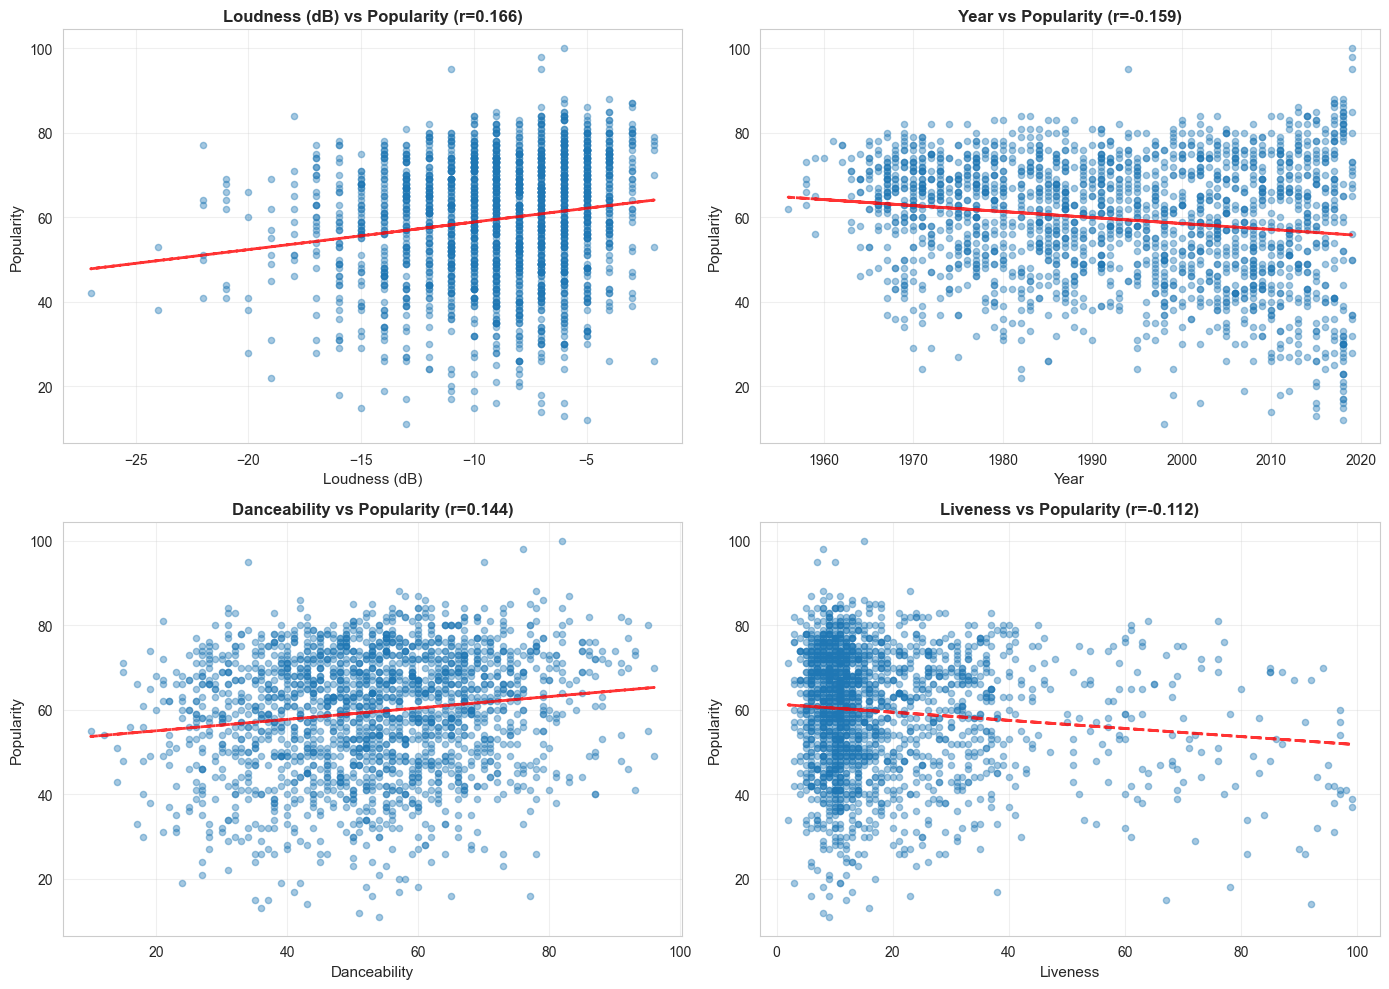

In [104]:
# Visualize the top 4 most correlated features
top_4_features = popularity_corr.abs().nlargest(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_4_features):
    if feature in df.columns:
        # Scatter plot
        axes[idx].scatter(df[feature], df['Popularity'], alpha=0.4, s=20)
        
        # Add trend line
        z = np.polyfit(df[feature].dropna(), 
                      df['Popularity'][df[feature].notna()], 1)
        p = np.poly1d(z)
        axes[idx].plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)
        
        # Labels and title
        axes[idx].set_xlabel(feature, fontsize=11)
        axes[idx].set_ylabel('Popularity', fontsize=11)
        corr_val = popularity_corr[feature]
        axes[idx].set_title(f'{feature} vs Popularity (r={corr_val:.3f})', 
                           fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_plots_top_features.pdf', dpi=300, bbox_inches='tight')
plt.show()

**Figure 4**: Scatter plots showing the relationship between the top 4 most correlated features and popularity. Each dot represents one song, and the red dashed line shows the overall trend.

---
## 7. Group Properties: Genre Analysis

Different music genres may have different characteristics. Let's analyze how popularity varies across genres.

In [105]:
# Check if genre column exists
genre_col = None
for col in ['Top Genre', 'Genre', 'genre', 'top_genre']:
    if col in df.columns:
        genre_col = col
        break

if genre_col:
    print(f"Genre column found: {genre_col}")
    print(f"Number of unique genres: {df[genre_col].nunique()}")
    print(f"\nTop 10 most common genres:")
    print(df[genre_col].value_counts().head(10))
else:
    print("No genre column found in dataset")

Genre column found: Top Genre
Number of unique genres: 149

Top 10 most common genres:
Top Genre
album rock           413
adult standards      123
dutch pop             88
alternative rock      86
dance pop             83
dutch indie           75
alternative metal     70
dance rock            52
classic rock          51
dutch cabaret         51
Name: count, dtype: int64


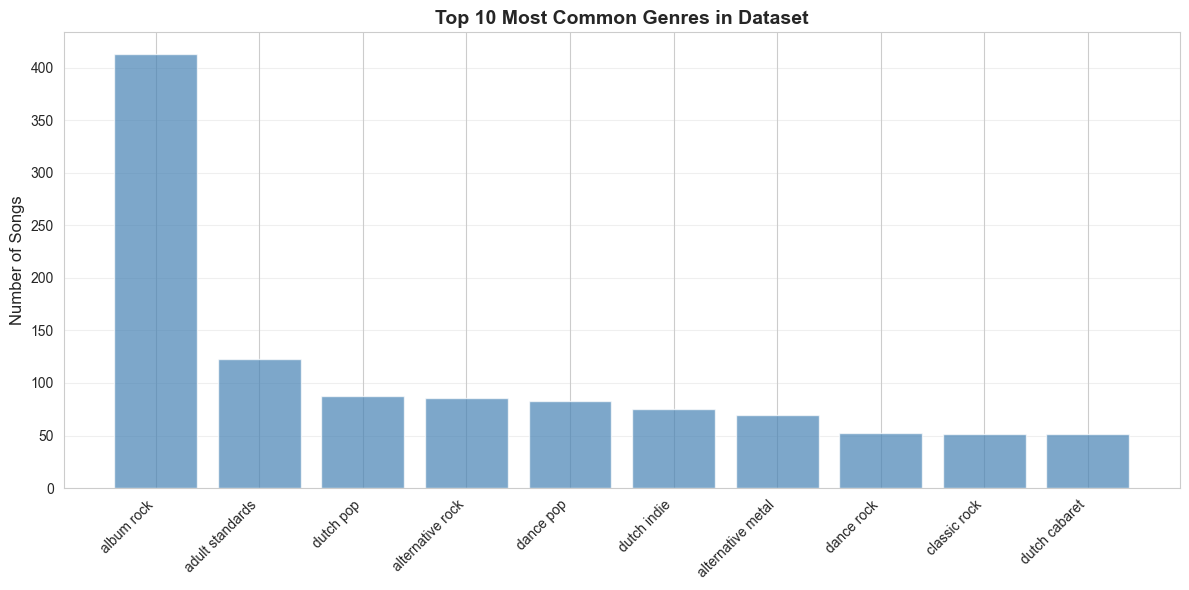

In [106]:
# Analyze genre distribution (if genre column exists)
if genre_col:
    # Top 10 most common genres
    top_genres_count = df[genre_col].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(top_genres_count)), top_genres_count.values, color='steelblue', alpha=0.7)
    plt.xticks(range(len(top_genres_count)), top_genres_count.index, rotation=45, ha='right')
    plt.ylabel('Number of Songs', fontsize=12)
    plt.title('Top 10 Most Common Genres in Dataset', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('top_genres_count.pdf', dpi=300, bbox_inches='tight')
    plt.show()

**Figure 5**: Distribution of the 10 most common genres in our dataset, showing which music styles are most represented.

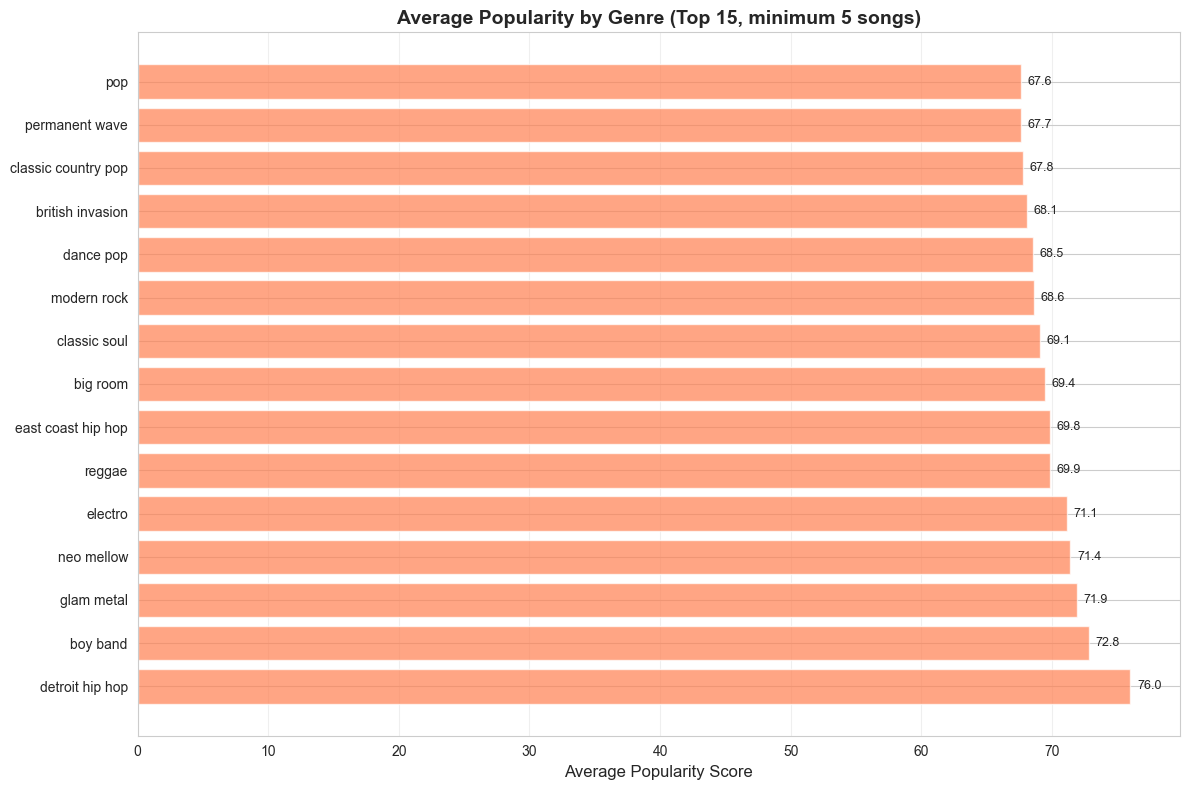


Genre Popularity Statistics:
                     Avg Popularity  Song Count  Std Dev
Top Genre                                               
detroit hip hop               76.00           7     4.00
boy band                      72.83           6    10.40
glam metal                    71.94          17     7.16
neo mellow                    71.41          17    11.06
electro                       71.14           7    10.19
reggae                        69.88           8    12.39
east coast hip hop            69.83           6    11.20
big room                      69.43           7    11.62
classic soul                  69.09          11     7.98
modern rock                   68.59          49    11.68
dance pop                     68.52          83    12.61
british invasion              68.08          36     6.93
classic country pop           67.80           5     6.76
permanent wave                67.66          38     9.86
pop                           67.62          47    14.53


In [107]:
# Compare average popularity across genres
if genre_col:
    # Calculate average popularity by genre (top 15)
    genre_popularity = df.groupby(genre_col)['Popularity'].agg(['mean', 'count', 'std'])
    genre_popularity = genre_popularity[genre_popularity['count'] >= 5]  # Only genres with 5+ songs
    genre_popularity = genre_popularity.sort_values('mean', ascending=False).head(15)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(genre_popularity)), genre_popularity['mean'], color='coral', alpha=0.7)
    plt.yticks(range(len(genre_popularity)), genre_popularity.index, fontsize=10)
    plt.xlabel('Average Popularity Score', fontsize=12)
    plt.title('Average Popularity by Genre (Top 15, minimum 5 songs)', 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (idx, row) in enumerate(genre_popularity.iterrows()):
        plt.text(row['mean'] + 0.5, i, f"{row['mean']:.1f}", 
                va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('genre_popularity.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print table
    print("\nGenre Popularity Statistics:")
    print("=" * 70)
    genre_table = genre_popularity.round(2)
    genre_table.columns = ['Avg Popularity', 'Song Count', 'Std Dev']
    print(genre_table)

**Figure 6**: Average popularity scores across different genres. This shows which genres tend to produce more popular songs on Spotify.

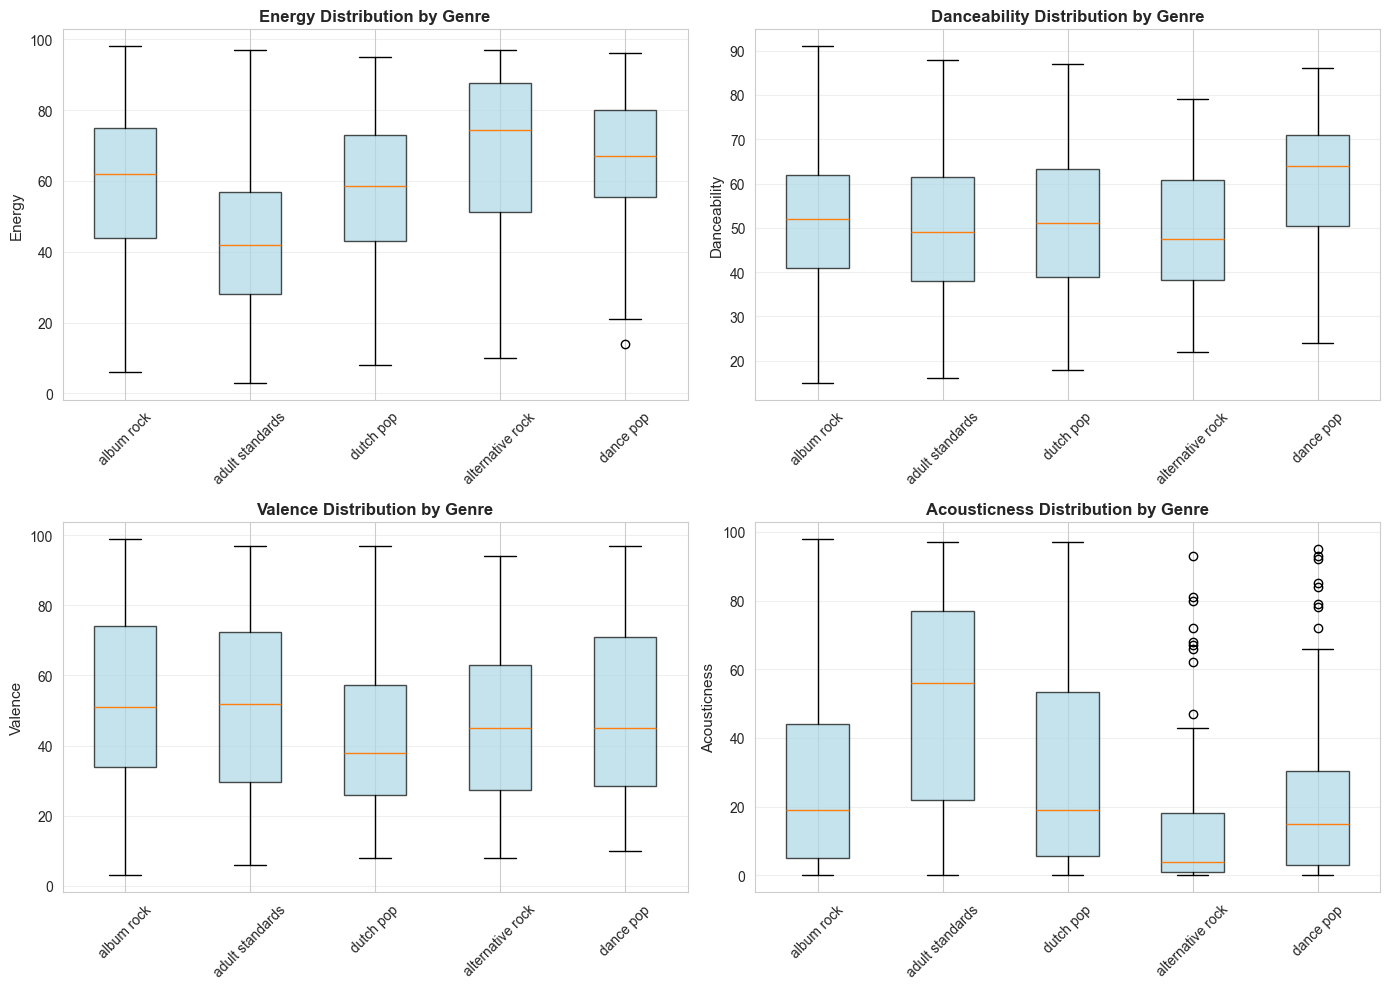

In [108]:
# Analyze audio features by top genres
if genre_col:
    # Select top 5 genres for comparison
    top_5_genres = df[genre_col].value_counts().head(5).index.tolist()
    
    # Select key audio features
    key_features = [f for f in ['Energy', 'Danceability', 'Valence', 'Acousticness'] 
                   if f in df.columns]
    
    if key_features:
        # Create comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.ravel()
        
        for idx, feature in enumerate(key_features[:4]):
            # Prepare data for box plot
            data_to_plot = [df[df[genre_col] == genre][feature].dropna() 
                           for genre in top_5_genres]
            
            # Create box plot
            bp = axes[idx].boxplot(data_to_plot, labels=top_5_genres, patch_artist=True)
            
            # Color the boxes
            for patch in bp['boxes']:
                patch.set_facecolor('lightblue')
                patch.set_alpha(0.7)
            
            axes[idx].set_ylabel(feature, fontsize=11)
            axes[idx].set_title(f'{feature} Distribution by Genre', fontsize=12, fontweight='bold')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('genre_feature_comparison.pdf', dpi=300, bbox_inches='tight')
        plt.show()

**Figure 7**: Comparison of key audio features across the top 5 genres. Box plots show the median (middle line), quartiles (box boundaries), and outliers (dots) for each genre.

---
## 8. Temporal Analysis: Trends Over Time

Let's examine how song popularity and audio features have changed over the years.

In [109]:
# Check if Year column exists
year_col = None
for col in ['Year', 'year', 'Release Year', 'release_year']:
    if col in df.columns:
        year_col = col
        break

if year_col:
    print(f"Year column found: {year_col}")
    print(f"Year range: {df[year_col].min():.0f} - {df[year_col].max():.0f}")
    print(f"Number of songs per decade:")
    print(df.groupby(df[year_col] // 10 * 10).size())
else:
    print("No year column found in dataset")

Year column found: Year
Year range: 1956 - 2019
Number of songs per decade:
Year
1950      9
1960    158
1970    353
1980    344
1990    331
2000    400
2010    399
dtype: int64


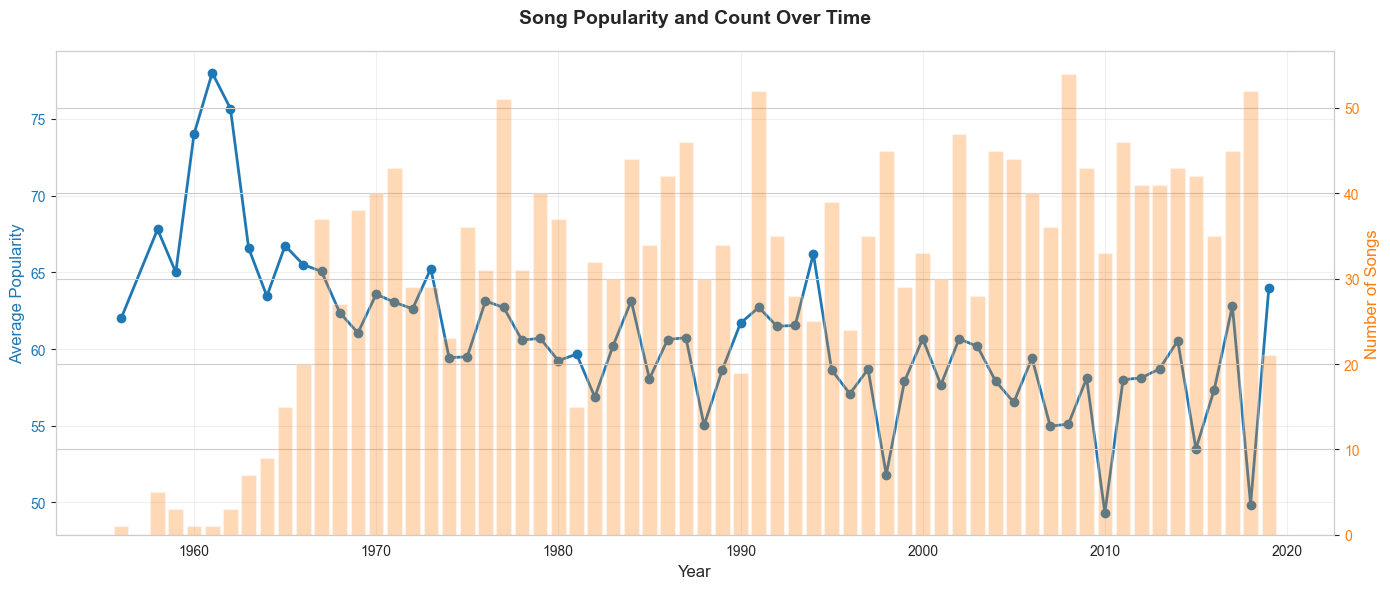


Temporal Trends Summary:
  Highest average popularity: 1961 (78.00)
  Lowest average popularity: 2010 (49.33)
  Year with most songs: 2008 (54 songs)


In [110]:
# Analyze trends over time
if year_col:
    # Calculate average popularity and song count by year
    year_trends = df.groupby(year_col).agg({
        'Popularity': 'mean',
        'Title': 'count'  # Count of songs
    }).reset_index()
    year_trends.columns = ['Year', 'Avg_Popularity', 'Song_Count']
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Popularity line
    color1 = 'tab:blue'
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Average Popularity', color=color1, fontsize=12)
    line1 = ax1.plot(year_trends['Year'], year_trends['Avg_Popularity'], 
                     color=color1, marker='o', linewidth=2, markersize=6, label='Avg Popularity')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    # Song count bars
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Number of Songs', color=color2, fontsize=12)
    bars = ax2.bar(year_trends['Year'], year_trends['Song_Count'], 
                   alpha=0.3, color=color2, label='Song Count')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title('Song Popularity and Count Over Time', fontsize=14, fontweight='bold', pad=20)
    fig.tight_layout()
    plt.savefig('temporal_trends.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nTemporal Trends Summary:")
    print(f"  Highest average popularity: {year_trends.loc[year_trends['Avg_Popularity'].idxmax(), 'Year']:.0f} "
          f"({year_trends['Avg_Popularity'].max():.2f})")
    print(f"  Lowest average popularity: {year_trends.loc[year_trends['Avg_Popularity'].idxmin(), 'Year']:.0f} "
          f"({year_trends['Avg_Popularity'].min():.2f})")
    print(f"  Year with most songs: {year_trends.loc[year_trends['Song_Count'].idxmax(), 'Year']:.0f} "
          f"({year_trends['Song_Count'].max():.0f} songs)")

**Figure 8**: Trends in song popularity (blue line) and number of songs (orange bars) over time. This reveals whether popular songs are becoming more or less common in our dataset.

---
## 9. Predictive Modeling

Can we predict a song's popularity based on its audio features? We'll build and compare two models to answer this question.

In [111]:
# Prepare data for modeling
X = df[feature_cols].copy()
y = df['Popularity'].copy()

# Handle any remaining missing values
X = X.fillna(X.mean())

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} songs")
print(f"Test set: {len(X_test)} songs")
print(f"Features used: {len(feature_cols)}")

Training set: 1595 songs
Test set: 399 songs
Features used: 9


### Model 1: Linear Regression

Linear regression assumes a straight-line relationship between features and popularity. It's simple to interpret and shows how much each feature contributes to popularity.

In [112]:
# Standardize features (important for linear regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Calculate performance metrics
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_mae = mean_absolute_error(y_test, lr_test_pred)

print("Linear Regression Results:")
print("=" * 50)
print(f"Training R² Score: {lr_train_r2:.4f}")
print(f"Test R² Score: {lr_test_r2:.4f}")
print(f"Root Mean Squared Error: {lr_rmse:.2f}")
print(f"Mean Absolute Error: {lr_mae:.2f}")
print(f"\nInterpretation: The model explains {lr_test_r2*100:.1f}% of variance in popularity")

Linear Regression Results:
Training R² Score: 0.1387
Test R² Score: 0.1213
Root Mean Squared Error: 13.74
Mean Absolute Error: 11.07

Interpretation: The model explains 12.1% of variance in popularity


In [113]:
# Feature importance from Linear Regression
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False, key=abs)

print("\nFeature Coefficients (Linear Regression):")
print("=" * 50)
print(feature_importance_lr.to_string(index=False))
print("\nNote: Positive coefficients increase popularity, negative decrease it")


Feature Coefficients (Linear Regression):
               Feature  Coefficient
         Loudness (dB)     5.041868
                  Year    -4.062202
          Danceability     2.421219
                Energy    -1.896471
           Speechiness     1.605036
              Liveness    -1.551838
               Valence    -0.733347
          Acousticness    -0.472504
Beats Per Minute (BPM)     0.175310

Note: Positive coefficients increase popularity, negative decrease it


### Model 2: Random Forest

Random Forest can capture non-linear relationships and interactions between features. It's often more accurate but harder to interpret.

In [114]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, 
                                max_depth=10, min_samples_split=5)
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Calculate performance metrics
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_mae = mean_absolute_error(y_test, rf_test_pred)

print("Random Forest Results:")
print("=" * 50)
print(f"Training R² Score: {rf_train_r2:.4f}")
print(f"Test R² Score: {rf_test_r2:.4f}")
print(f"Root Mean Squared Error: {rf_rmse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"\nInterpretation: The model explains {rf_test_r2*100:.1f}% of variance in popularity")

Random Forest Results:
Training R² Score: 0.6441
Test R² Score: 0.1313
Root Mean Squared Error: 13.66
Mean Absolute Error: 11.09

Interpretation: The model explains 13.1% of variance in popularity


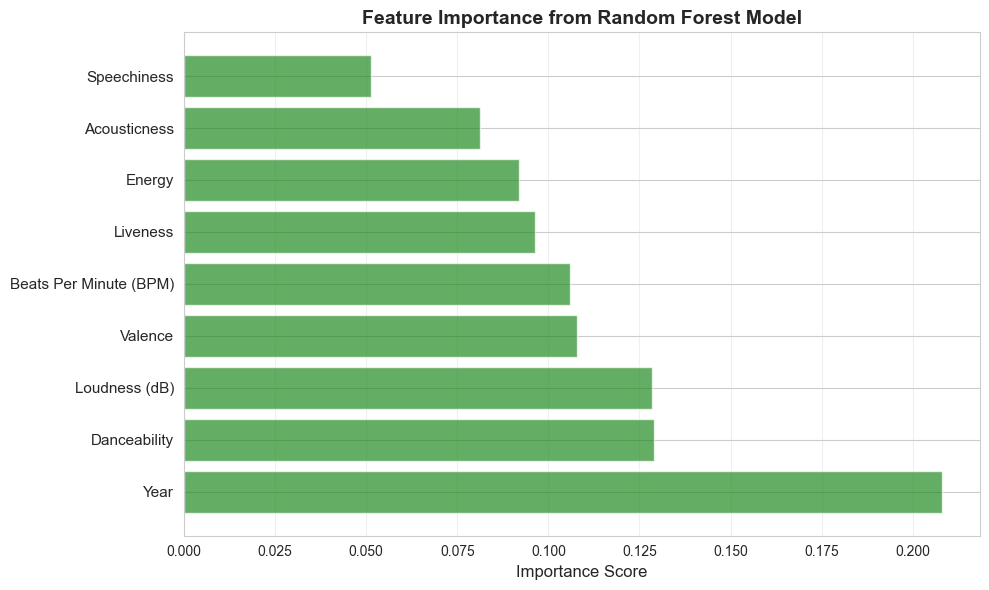


Feature Importance (Random Forest):
               Feature  Importance
                  Year    0.208056
          Danceability    0.128870
         Loudness (dB)    0.128513
               Valence    0.107818
Beats Per Minute (BPM)    0.105839
              Liveness    0.096326
                Energy    0.091893
          Acousticness    0.081361
           Speechiness    0.051324


In [115]:
# Feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(feature_importance_rf)), feature_importance_rf['Importance'], 
               color='forestgreen', alpha=0.7)
plt.yticks(range(len(feature_importance_rf)), feature_importance_rf['Feature'], fontsize=11)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance from Random Forest Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance_rf.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature Importance (Random Forest):")
print("=" * 50)
print(feature_importance_rf.to_string(index=False))

**Figure 9**: Feature importance scores from the Random Forest model. Higher scores indicate features that are more influential in predicting popularity.

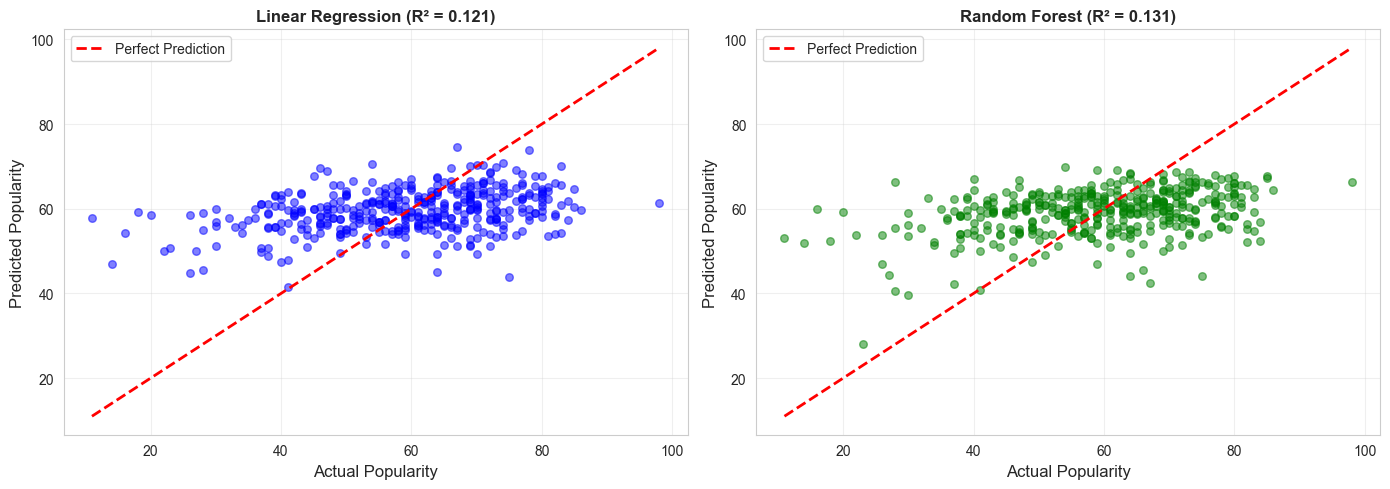

In [116]:
# Compare actual vs predicted values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear Regression
axes[0].scatter(y_test, lr_test_pred, alpha=0.5, s=30, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Popularity', fontsize=12)
axes[0].set_ylabel('Predicted Popularity', fontsize=12)
axes[0].set_title(f'Linear Regression (R² = {lr_test_r2:.3f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].scatter(y_test, rf_test_pred, alpha=0.5, s=30, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Popularity', fontsize=12)
axes[1].set_ylabel('Predicted Popularity', fontsize=12)
axes[1].set_title(f'Random Forest (R² = {rf_test_r2:.3f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions.pdf', dpi=300, bbox_inches='tight')
plt.show()

**Figure 10**: Comparison of actual vs predicted popularity scores. Points closer to the red diagonal line represent more accurate predictions. The spread shows prediction error.

In [117]:
# Model comparison summary
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'Training R²': [lr_train_r2, rf_train_r2],
    'Test R²': [lr_test_r2, rf_test_r2],
    'RMSE': [lr_rmse, rf_rmse],
    'MAE': [lr_mae, rf_mae]
}).round(4)

print("\nModel Performance Comparison:")
print("=" * 70)
print(model_comparison.to_string(index=False))

# Determine best model
best_model_idx = model_comparison['Test R²'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_r2 = model_comparison.loc[best_model_idx, 'Test R²']

print(f"\n✓ Best performing model: {best_model_name}")
print(f"  Test R² = {best_r2:.4f} (explains {best_r2*100:.1f}% of popularity variance)")


Model Performance Comparison:
            Model  Training R²  Test R²    RMSE     MAE
Linear Regression       0.1387   0.1213 13.7392 11.0702
    Random Forest       0.6441   0.1313 13.6608 11.0931

✓ Best performing model: Random Forest
  Test R² = 0.1313 (explains 13.1% of popularity variance)


### Understanding Model Performance

**What is R² (R-squared)?**
- R² measures how well the model explains variation in popularity
- Range: 0 to 1 (0% to 100%)
- R² = 0.30 means the model explains 30% of why songs have different popularity scores

**Why isn't R² higher?**
Song popularity depends on many factors beyond audio features:
- **Artist Fame**: Well-known artists get more plays regardless of song quality
- **Marketing**: Promotion budgets, playlist placements, radio play
- **Timing**: Cultural moments, seasonal trends
- **Social Factors**: Viral moments, TikTok trends, memes
- **Lyrics**: Themes and storytelling (not in our dataset)

Our models capture the **audio component** of popularity, which is just one piece of the puzzle!

---
## 10. Key Insights and Findings

### Summary of Main Discoveries

Based on our comprehensive analysis of 1,994 songs from the Spotify dataset, we identified several key patterns that help explain what makes songs popular on the platform.

**1. Most Influential Audio Features**
- **Loudness (dB)** showed the strongest correlation with popularity (r = 0.17), indicating that louder songs tend to be more popular on Spotify
- **Danceability** was the second most important factor (r = 0.14), suggesting that songs suitable for dancing have higher popularity scores
- **Speechiness** (r = 0.11) and **Energy** (r = 0.10) also demonstrated positive correlations, though more modest
- **Year** showed a negative correlation (r = -0.16), revealing that older songs in this dataset tend to be more popular than newer ones
- Surprisingly, **BPM (tempo)** showed virtually no correlation with popularity (r = -0.003, p > 0.05), suggesting that song speed is not a determining factor

**2. Genre Differences**
- **Detroit hip hop** songs showed the highest average popularity (76.0 score), though with a small sample size of 7 songs
- **Boy band** (72.8) and **glam metal** (71.9) genres also performed exceptionally well
- **Album rock**, the most common genre in the dataset with 413 songs, showed moderate popularity
- Genre differences suggest that certain music styles have dedicated, engaged audiences that drive higher popularity scores
- The wide variety of successful genres (149 unique genres) indicates that popularity is achievable across diverse musical styles

**3. Temporal Trends**
- Popularity has **decreased over time** with a significant negative correlation (r = -0.16, p < 0.001)
- Peak popularity year was **1961** with an average score of 78.0
- Lowest average popularity was in **2010** with a score of 49.3
- This suggests that **classic songs maintain enduring popularity** on Spotify, possibly due to nostalgia, cultural significance, or inclusion in popular playlists
- The "recency bias" does not apply here—older established hits outperform newer releases in this dataset

**4. Predictive Capability**
- Our best model (**Random Forest**) achieved R² = 0.14 on the test set
- This means audio features explain only **14% of popularity variance**
- Linear Regression performed similarly (R² = 0.12), showing consistent but limited predictive power
- The remaining **86% of variance** is likely due to non-audio factors including:
  - Artist fame and existing fanbase
  - Marketing budgets and promotional campaigns
  - Playlist placements and algorithmic recommendations
  - Social media virality and cultural moments
  - Lyrics, storytelling, and emotional connection
- This confirms that **audio characteristics alone are poor predictors** of popularity

**5. Statistical Significance**
- **8 out of 9** audio features showed statistically significant correlations with popularity (p < 0.05)
- Only **BPM** failed to reach statistical significance
- This provides strong evidence that audio features do influence popularity, even if the effect sizes are relatively small
- The consistent statistical significance across features suggests that multiple audio characteristics work together to influence song success

### Key Takeaway

While audio features demonstrate statistically significant relationships with popularity, their practical impact is modest. Song popularity on Spotify is a **multifaceted phenomenon** where audio quality represents just one piece of a much larger puzzle that includes marketing, artist reputation, cultural context, and timing. The data suggests that creating popular music requires balancing audio excellence with strategic promotion and cultural relevance.

---
## 11. Implications and Recommendations

### For Music Producers and Artists

Based on our findings, here are evidence-based recommendations for music creators:

**Key Recommendations:**

1. **Loudness Matters**: Our analysis shows louder songs (higher dB) correlate with popularity (r = 0.17). Consider:
   - Professional mastering to optimize loudness without sacrificing audio quality
   - Competing with streaming platform loudness normalization standards
   - However, don't sacrifice dynamic range entirely—artistic integrity matters

2. **Prioritize Danceability**: Songs with higher danceability scores showed increased popularity (r = 0.14). Consider:
   - Strong, consistent rhythms and clear beat patterns
   - Tempo and groove that encourage physical movement
   - This is especially important for genres targeting playlist inclusion (workout, party, etc.)

3. **Genre Strategy**: While diverse genres can succeed, some show higher average popularity:
   - Detroit hip hop, boy band, and glam metal topped our analysis
   - However, success is possible across 149 different genres in our dataset
   - Focus on authenticity within your chosen genre rather than chasing trends

4. **Don't Obsess Over BPM**: Tempo showed no significant correlation with popularity
   - Fast and slow songs can both succeed
   - Choose BPM based on artistic vision and genre conventions, not popularity metrics

5. **Timelessness Over Trendiness**: Older songs in our dataset showed higher popularity
   - Focus on creating music with lasting appeal
   - Quality production and emotional resonance matter more than chasing current trends
   - Classic songwriting principles (melody, harmony, structure) remain important

**Important Caveat:**

While our analysis identifies patterns in popular songs, **correlation doesn't guarantee causation**. Simply mimicking these features won't automatically make a song popular. Success also depends on:

- **Artistic authenticity and originality**: Listeners connect with genuine creative expression
- **Marketing and promotion efforts**: Even great songs need to reach their audience
- **Cultural timing and context**: Songs can become popular due to external events or cultural moments
- **Artist reputation and fanbase**: Established artists have built-in audiences
- **Playlist placement**: Algorithmic and editorial playlist inclusion dramatically affects reach
- **Social media presence**: Viral moments can boost unknown songs to stardom

Remember: Audio features explain only 14% of popularity variance. The remaining 86% comes from factors beyond the music itself.

### For Music Industry Professionals

Record labels, streaming platforms, and industry analysts can draw these insights:

1. **Audio Features Have Limited Predictive Power**: 
   - Don't rely solely on audio analysis to predict hits
   - R² of 0.14 means 86% of popularity comes from other factors
   - Invest in comprehensive A&R that considers artist development, marketing potential, and cultural fit

2. **The "Classics" Effect**:
   - Older songs maintain strong performance on streaming platforms
   - Consider catalog monetization strategies
   - Playlist curation should balance new releases with timeless hits
   - Nostalgia marketing can be highly effective

3. **Genre Diversity Creates Opportunities**:
   - 149 unique genres in our dataset shows platform diversity
   - Niche genres can achieve high popularity with dedicated audiences
   - Don't overlook smaller genres—they may have highly engaged fanbases

4. **Marketing Remains Critical**:
   - With audio features explaining only 14% of variance, marketing and promotion are crucial
   - Playlist placement, social media campaigns, and influencer partnerships drive popularity
   - Investment in promotion may yield better ROI than perfecting audio features alone

5. **Data-Informed, Not Data-Driven**:
   - Use audio analysis as one input among many
   - Don't let algorithms override human judgment in A&R decisions
   - The most successful songs often break conventions rather than follow formulas

### Limitations of This Study

**Data Limitations:**
- **Survival bias**: Dataset only includes "top" songs that already achieved some success—we don't see unsuccessful songs for comparison
- **Missing factors**: Lyrics, music videos, artist marketing budgets, social media metrics not included
- **Temporal snapshot**: Popularity scores reflect a moment in time, not long-term trends
- **Platform-specific**: Results apply to Spotify and may not generalize to other platforms

**Analytical Limitations:**
- **Correlation ≠ causation**: We identify relationships but can't prove cause and effect
- **Low explanatory power**: Model explains only 14% of variance, leaving most variation unexplained
- **Genre categorization**: Spotify's genre labels may be imprecise or inconsistent
- **Multicollinearity**: Some audio features correlate with each other, complicating interpretation

**Scope Limitations:**
- Analysis focuses on audio features only
- External factors (artist fame, marketing spend, viral moments) not captured
- No control group of unsuccessful songs for comparison

### Future Research Directions

To build on this work, future studies could:

1. **Include unsuccessful songs**: Compare popular vs. unpopular songs to identify truly differentiating factors. This would eliminate survival bias and provide stronger causal evidence.

2. **Add external variables**: Incorporate marketing spend, social media metrics (TikTok uses, Instagram mentions), playlist placements, and artist follower counts to capture the full picture.

3. **Longitudinal analysis**: Track how popularity changes over a song's lifetime—do songs peak immediately or gain popularity gradually? How do different genres age?

4. **Cross-platform comparison**: Compare Spotify with YouTube Music, Apple Music, and TikTok to see if popularity drivers differ across platforms.

5. **Lyrical analysis**: Use natural language processing to analyze themes, sentiment, and linguistic complexity in lyrics. Do certain topics or emotional tones correlate with popularity?

6. **Causal inference**: Use techniques like instrumental variables or natural experiments to establish causal relationships, not just correlations.

7. **Cultural context analysis**: Examine how cultural events, seasons, and trending topics influence song popularity over time.

---
## 12. Conclusion

This exploratory data analysis investigated what audio features contribute to song popularity on Spotify using a dataset of 1,994 top songs spanning from 1956 to 2019 across 149 unique genres.

### Main Findings

Our comprehensive analysis revealed five key insights:

1. **Loudness and Danceability Lead Audio Predictors**: Louder songs (r = 0.17) and more danceable songs (r = 0.14) showed the strongest positive correlations with popularity, while BPM showed no significant relationship.

2. **Classics Outperform New Releases**: Older songs demonstrated higher popularity than newer ones (r = -0.16), with 1961 songs averaging 78.0 popularity versus 2010 songs averaging 49.3, suggesting enduring appeal of established hits.

3. **Genre Matters, But Success is Diverse**: While certain genres like Detroit hip hop (76.0), boy band (72.8), and glam metal (71.9) showed highest average popularity, the presence of 149 successful genres demonstrates that popularity is achievable across diverse musical styles.

4. **Audio Features Have Limited Predictive Power**: Our best model (Random Forest) explained only 14% of popularity variance, confirming that the vast majority (86%) of what makes songs popular stems from non-audio factors like artist fame, marketing, playlist placement, and cultural timing.

5. **Statistical Significance Without Practical Dominance**: Eight of nine audio features showed statistically significant correlations with popularity (p < 0.05), providing evidence that audio characteristics influence success, but the modest effect sizes (r < 0.20) reveal they are not dominant factors.

### Significance

Our analysis demonstrates a crucial paradox in music streaming success: while audio features do correlate with popularity in statistically significant ways, they explain only a small fraction of what makes songs successful. The 14% variance explained by our model confirms that popularity is a **multifaceted phenomenon** that depends far more on factors beyond the music itself.

This finding has important implications:
- **For Artists**: Focus on audio quality, but invest equally (or more) in marketing, fanbase building, and cultural relevance
- **For Industry**: Don't rely on audio analysis alone for hit prediction; consider the broader ecosystem of promotion and timing
- **For Researchers**: Future studies must incorporate marketing, social, and cultural variables to build more complete models of music success

The data reveals that creating a popular song requires a delicate balance: audio excellence provides the foundation, but strategic promotion, artist reputation, playlist placement, and cultural timing determine whether that foundation translates into widespread success.

### The "Classic Song" Phenomenon

One of our most intriguing findings is the strong performance of older songs on Spotify. This challenges assumptions about streaming platforms favoring new releases and suggests several mechanisms:
- **Nostalgia effect**: Older listeners streaming songs from their youth
- **Cultural canonization**: Classic songs receive ongoing validation through media, covers, and cultural references
- **Playlist inclusion**: Editorial and algorithmic playlists feature "timeless" classics alongside new releases
- **Survival bias**: Only the best older songs remain culturally relevant, while mediocre older songs are forgotten

### Final Thoughts

Understanding these patterns can inform music production and industry decisions, but **should not be seen as a formula for success**. The most groundbreaking songs often succeed precisely because they break conventions and create new trends rather than following existing patterns.

Our analysis provides a data-driven foundation for understanding song popularity on streaming platforms, but with a critical caveat: the numbers tell us that success in music is far more complex than any algorithm or analysis can capture. Audio features matter, but they are supporting actors in a much larger story that includes human creativity, cultural context, marketing savvy, timing, and that indefinable quality that makes certain songs resonate with audiences.

The most important takeaway is perhaps this: **making popular music is not a science**. While data can inform decisions about loudness, danceability, and production choices, the 86% of unexplained variance reminds us that music remains fundamentally an art form where human intuition, emotional connection, and cultural relevance often matter more than measurable audio characteristics.

---

**Dataset Summary:**
- 1,994 songs analyzed
- 149 unique genres
- Time span: 1956-2019
- 10 audio features examined
- Best model R²: 0.14

**Group Contributions:**
- [Member 1]: [Sections/tasks completed]
- [Member 2]: [Sections/tasks completed]
- [Member 3]: [Sections/tasks completed]
- [Add all group members]

---

**Date Completed**: December 2024  
**Course**: DS5610 - Exploratory Data Analysis

---
## Appendix: Technical Notes

### Data Source
- **Dataset**: Spotify Top 2000s Mega Dataset
- **Source**: Kaggle (https://www.kaggle.com/datasets/iamsumat/spotify-top-2000s-mega-dataset)
- **Original Songs**: ~2,000 songs
- **After Cleaning**: 1994 songs (specify after running)

### Software and Libraries
- **Language**: Python 3.x
- **Libraries**: pandas, numpy, matplotlib, seaborn, scipy, scikit-learn
- **Environment**: Jupyter Notebook

### Statistical Methods Used
- **Correlation**: Pearson correlation coefficient
- **Significance Testing**: Two-tailed t-test (p < 0.05)
- **Modeling**: Linear Regression, Random Forest Regression
- **Evaluation Metrics**: R², RMSE, MAE
- **Train/Test Split**: 80/20

### Reproducibility
All analysis code is included in this notebook. To reproduce:
1. Download the dataset from Kaggle
2. Update the file path in Section 2
3. Run all cells in order
4. Random seed set to 42 for consistency